在GP应用场景中，一个常见的情况是对于多树GP，我们需要每棵GP树使用不同的算子或变量。例如，在下面这篇TEVC论文中：

TEVC 2024 "Modular Multi-Tree Genetic Programming for Evolutionary Feature Construction for Regression"

多棵GP树需要不同算子的情况在运筹优化、图像处理等领域也是很常见的。

这篇文章主要讲述如何在GP中实现多棵GP树，每棵GP树使用不同的算子或变量。


In [13]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression

# 假设我们有一个回归问题，输入为X，输出为y
X, y = load_diabetes(return_X_y=True)


# 求解问题的目标是最大化回归精度
def evalFeatureEngineering(individuals,psets):
    # 创建新特征
    new_features = []
    for ind_num, ind in enumerate(individuals):
        func = gp.compile(expr=ind, pset=psets[ind_num])
        results = func(*X.T)
        if results.size == 1:
            results=np.full(X.shape[0], results)
        new_features.append(results)

    # 使用交叉验证计算误差
    new_features = np.transpose(np.array(new_features))
    clf = LinearRegression()
    scores = cross_val_score(clf, new_features, y, cv=5)

    # 返回平均分类精度
    return (scores.mean(),)

### 创建多个Primitive Set
在GP中，不同树使用不同算子是一个常见的场景。为此，一个简单的方法是创建多个Primitive Set，每个Primitive Set对应一棵树所使用的Functions和Terminals。

In [14]:
import operator
import random
import numpy as np
from deap import base, creator, tools, gp, algorithms
from sklearn.model_selection import cross_val_score

# 创建GP框架的基本组件
psets=[]
for idx in range(5):
    pset = gp.PrimitiveSet("MAIN", X.shape[1])
    if idx==0:
        pset.addPrimitive(np.add, 2)
        pset.addPrimitive(np.subtract, 2)
        pset.addPrimitive(np.multiply, 2)
        pset.addPrimitive(np.sin, 1)
        pset.addPrimitive(np.cos, 1)
    else:
        pset.addPrimitive(np.add, 2)
        pset.addPrimitive(np.subtract, 2)
        pset.addPrimitive(np.multiply, 2)
        pset.addPrimitive(np.negative, 1)
    pset.addEphemeralConstant("rand101", lambda: random.random() * 2 - 1)
    psets.append(pset)

# 创建一个适应度类和个体类，个体由多棵树组成
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

C:\Users\zhenl\anaconda3\Lib\site-packages\deap\gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "
C:\Users\zhenl\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\zhenl\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### 定义算子
由于定义了多个Primitive Set，我们需要对相关算子进行修改，以处理多个Primitive Set的情况。简单来说，主要是修改初始化和变异算子。

In [15]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, min_=1, max_=6)


# 初始化每个个体为一个包含多棵树的列表
def initIndividual(container, func, size):
    return container(gp.PrimitiveTree(func(pset=psets[idx])) for idx in range(size))


# 交叉和变异算子需要能够处理个体的列表结构
def cxOnePointListOfTrees(ind1, ind2):
    for idx, (tree1, tree2) in enumerate(zip(ind1, ind2)):
        HEIGHT_LIMIT = 10
        dec = gp.staticLimit(key=operator.attrgetter("height"), max_value=HEIGHT_LIMIT)
        tree1, tree2 = dec(gp.cxOnePoint)(tree1, tree2)
        ind1[idx], ind2[idx] = tree1, tree2
    return ind1, ind2


def mutUniformListOfTrees(individual, expr, psets):
    for idx, tree in enumerate(individual):
        HEIGHT_LIMIT = 10
        dec = gp.staticLimit(key=operator.attrgetter("height"), max_value=HEIGHT_LIMIT)
        tree, = dec(gp.mutUniform)(tree, expr=expr, pset=psets[idx])
        individual[idx] = tree
    return (individual,)

# 假设我们创建3个特征
toolbox.register("individual", initIndividual, creator.Individual, toolbox.expr, size=3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalFeatureEngineering,psets=psets)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", cxOnePointListOfTrees)
toolbox.register("mutate", mutUniformListOfTrees, expr=toolbox.expr, psets=psets)
toolbox.register("compile", gp.compile)

### 运行遗传编程算法
最后，我们可以运行遗传编程算法，来看看生成的树是否是根据多个Primitive Set生成的。

In [16]:
# 运行遗传编程算法
population = toolbox.population(n=50)
hof = tools.HallOfFame(1)

# 统计和日志
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)
stats_size = tools.Statistics(key=lambda ind: max([tree.height for tree in ind]))
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(population, toolbox, 0.9, 0.1, 10, stats=mstats, halloffame=hof, verbose=True)

# 查看最佳个体
best_ind = hof[0]
for idx, tree in enumerate(best_ind):
    print('Tree ', idx)
    print(str(tree))
print('With fitness:', best_ind.fitness.values)

   	      	                                fitness                                 	                      size                     
   	      	------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min       	nevals	std     	avg 	gen	max	min	nevals	std    
0  	50    	0.169861	0  	0.399341	-0.0375021	50    	0.125613	4.06	0  	6  	1  	50    	1.56729
1  	42    	0.250583	1  	0.43575 	0.0371289 	42    	0.0930731	4.18	1  	9  	1  	42    	1.68155
2  	44    	0.286585	2  	0.444997	0.0728751 	44    	0.085748 	4.64	2  	9  	2  	44    	1.93659
3  	48    	0.302849	3  	0.462661	-0.0259395	48    	0.113096 	5.38	3  	9  	2  	48    	2.18989
4  	44    	0.321165	4  	0.455546	0.107115  	44    	0.095439 	5.64	4  	9  	2  	44    	1.87361
5  	48    	0.320487	5  	0.45911 	-0.0145533	48    	0.118921 	6.18	5  	10 	2  	48    	2.1697 
6  	46    	0.376395	6  	0.45911 	0.106767  	46    	0.0749688	6.94	6  	10 	3  	46    	2.

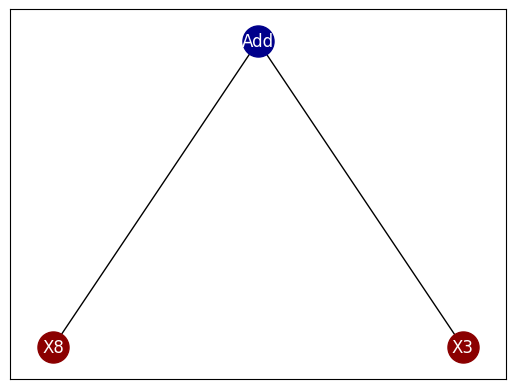

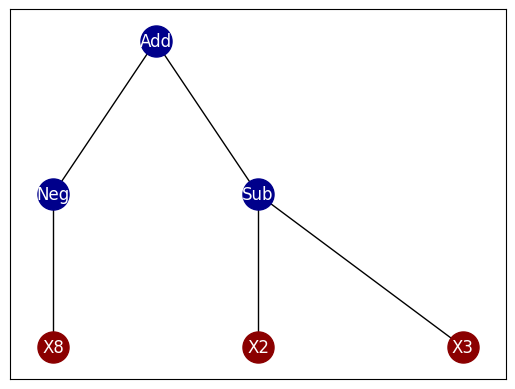

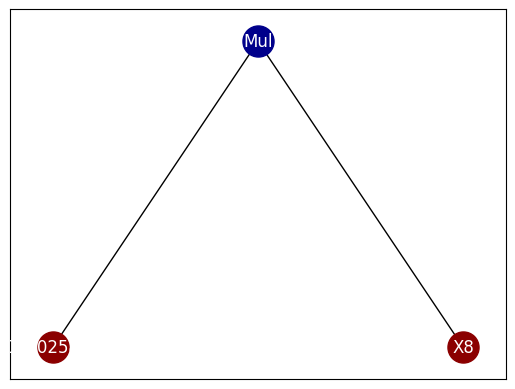

In [17]:
from matplotlib import pyplot as plt
import networkx as nx
from deap.gp import graph
from networkx.drawing.nx_agraph import graphviz_layout

function_name = {
    'add': 'Add',
    'sub': 'Sub',
    'subtract': 'Sub',
    'mul': 'Mul',
    'multiply': 'Mul',
    'neg': 'Neg',
    'sin': 'sin',
    'cos': 'cos',
    'negative': 'Neg',
}

def is_number(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

def plot_a_tree(tree=hof[0]):
    red_nodes = []
    purple_nodes = []
    blue_nodes = []
    for gid, g in enumerate(tree):
        if (
                hasattr(g, "value")
                and isinstance(g.value, str)
                and g.value.startswith("ARG")
        ):
            g.value = g.value.replace("ARG", "X")

        if g.name in function_name:
            g.name = function_name[g.name]

        if hasattr(g, "value") and (
                is_number(g.value)
                or (g.value.startswith("X") and int(g.value[1:]) < X.shape[1])
        ):
            # 基础节点
            red_nodes.append(gid)
        elif hasattr(g, "value") and g.value.startswith("X"):
            g.value = "$\phi$" + str(int(g.value.replace("X", "")) - X.shape[1] + 1)
            purple_nodes.append(gid)
        elif hasattr(g, "value") and g.value.startswith("$\phi$"):
            purple_nodes.append(gid)
        else:
            # 深蓝色节点
            blue_nodes.append(gid)
    nodes, edges, labels = graph(tree)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = graphviz_layout(g, prog="dot")
    red_nodes_idx = [nodes.index(n) for n in nodes if n in red_nodes]
    purple_nodes_idx = [nodes.index(n) for n in nodes if n in purple_nodes]
    blue_nodes_idx = [nodes.index(n) for n in nodes if n in blue_nodes]
    nx.draw_networkx_nodes(
        g, pos, nodelist=red_nodes_idx, node_color="darkred", node_size=500
    )
    nx.draw_networkx_nodes(
        g, pos, nodelist=purple_nodes_idx, node_color="indigo", node_size=500
    )
    nx.draw_networkx_nodes(
        g, pos, nodelist=blue_nodes_idx, node_color="darkblue", node_size=500
    )
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels, font_color="white")

for tree in hof[0]:
    plot_a_tree(tree)
    plt.show()

从上面的结果可以看出，每棵树使用了不同的算子。例如，第一棵树中使用了sin算子，而其他树没有使用sin算子。